## TP 3 - Visión por Computadora 1

### Carrera de Especialización en Inteligencia Artificial - Cohorte 17

### Autora: Micozzi, María Luz - a1707

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [ ]:
# imports
import numpy as np
import cv2 as cv

import sys
sys.path.append('../utils')
from functions import read_images, show_images

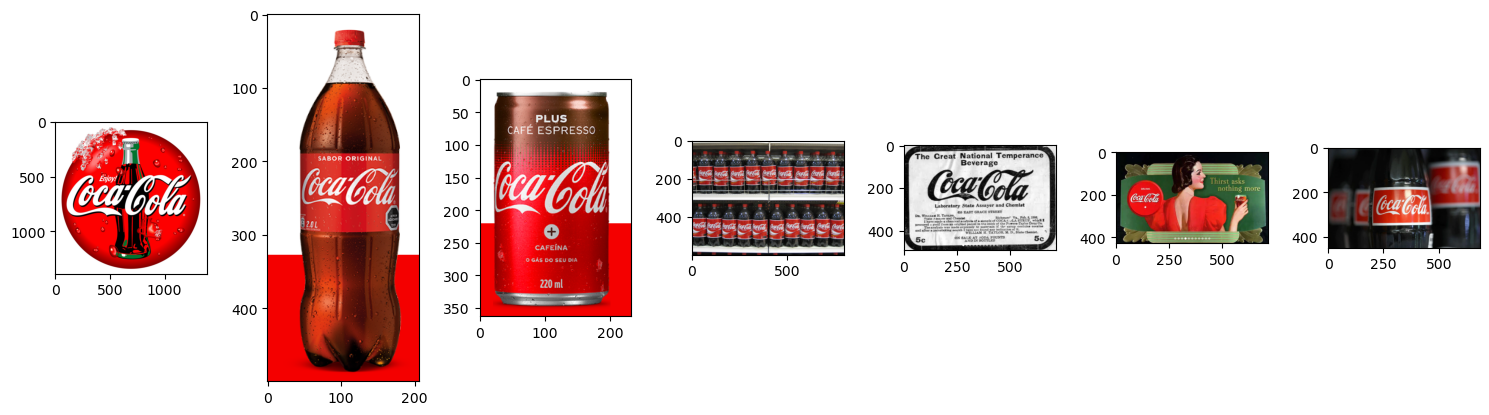

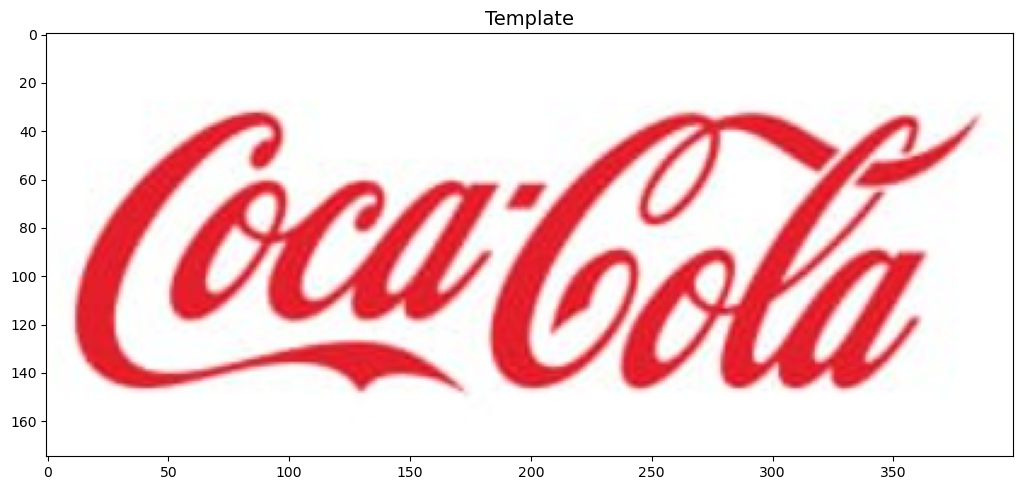

In [2]:
# leemos y mostramos las imágenes y el template
images = read_images('images')
show_images(images, [])
templates = read_images('template')
template = templates[0]
show_images(templates, ['Template'])

Vemos que las imágenes y el template tienen diferentes escalas, lo cual es un factor a tener en cuenta para la correcta detección.
Por otro lado, viendo las diferencias en intensidad, sombras e iluminación aplicaremos Canny para hacer el matching utilizando los bordes.

### 1. Obtener una detección del logo en cada imagen sin falsos positivos

##### Primero exploramos aplicando los 6 métodos de match template sobre las distintas imágenes para seleccionar el mejor método.
##### Se probarán distintas escalas para cada imagen para buscar el mejor resultado para cada método.

In [3]:
def mark_template(image: np.ndarray, match: list) -> np.ndarray:
    """
    Recibe una imagen y los datos de ubicación donde se detectó el template.
    Devuelve la imagen con el template marcado con un recuadro.

    :param image: Imagen en la cual se quiere marcar el template
    :type image: np.ndarray
    :param match: Datos de escala y ubicación donde se detectó el template
    :type match: list
    :returns: Imagen con el temprante marcado
    :rtype: np.ndarray
    """
    
    _, match_location, match_shape_temple, match_scale = match
    x1, y1 = int(match_location[0]/match_scale), int(match_location[1]/match_scale)    
    h, w = int(match_shape_temple[0]/match_scale), int(match_shape_temple[1]/match_scale)
    x2, y2 = x1 + w, y1 + h

    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 5)

    return image

In [4]:
def match_template_single_detection_test_methods(img: np.ndarray, template: np.ndarray, methods: list) -> None:
    """
    Recibe una imagen, un template y una lista de methods de match template.
    Prueba los distintos métodos para comparar.

    :param img: Imagen en la cual se quiere detectar el template
    :type img: np.ndarray
    :param template: Template a detectar en la imagen
    :type template: np.ndarray
    :param methods: Lista de methods de match template
    :type methods: list
    """

    images = []

    # conviertimos el template a escala de grises y aplicamos Canny
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    template_edges = cv.Canny(template_gray, 100, 200, L2gradient=True)
    
    # iteramos sobre los distintos metodos de match template
    for method in methods :

        # conviertimos la imagen a escala de grises
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # definimos las escalas
        h_image, w_image, _ = img.shape
        h_template, w_template  = template_edges.shape

        max_scale = 5.0
        min_scale = max(h_template / h_image, w_template / w_image)
        scales = np.linspace(min_scale, max_scale, 100)

        best_results = []

        # iteramos sobre todas las escalas para buscar el mejor resultado
        for scale in scales:
            
            # escalamos y aplicamos Canny a la imagen
            img_scaled = cv.resize(img_gray, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)
            
            # aplicamos matchTemplate y buscamos el mejor resultado según el método usado

            result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            if method in ['TM_SQDIFF', 'TM_SQDIFF_NORMED']:
                best_match_value = min_val
                best_match_location = min_loc
                if best_results == [] or best_match_value < best_results[0]:
                    best_results = [best_match_value, best_match_location, (template_edges.shape), scale]
            else:
                best_match_value = max_val
                best_match_location = max_loc
                if best_results == [] or best_match_value > best_results[0]:
                    best_results = [best_match_value, best_match_location, (template_edges.shape), scale]
            
        # agregamos el borde a la imagen marcando donde se detectó el template
        img_plot = mark_template(img.copy(), best_results)
        images.append(img_plot)

    # gráficamos las imágenes para los distintos métodos, mostrando donde se detectó el template
    show_images(images, methods)

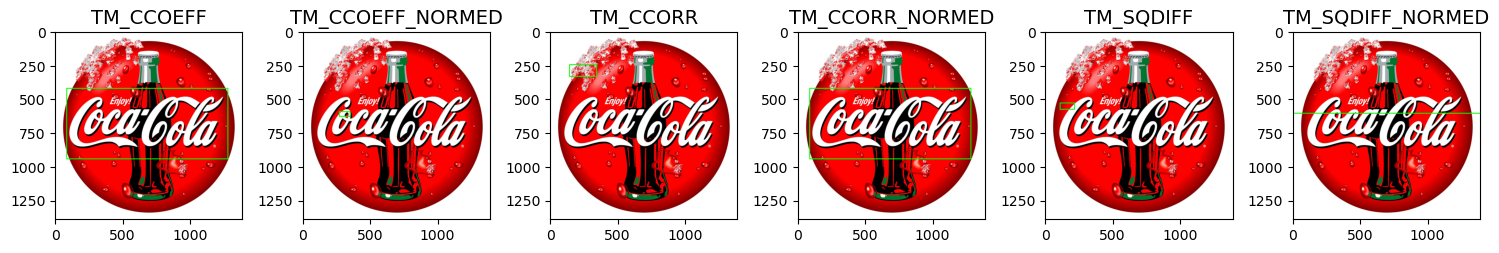

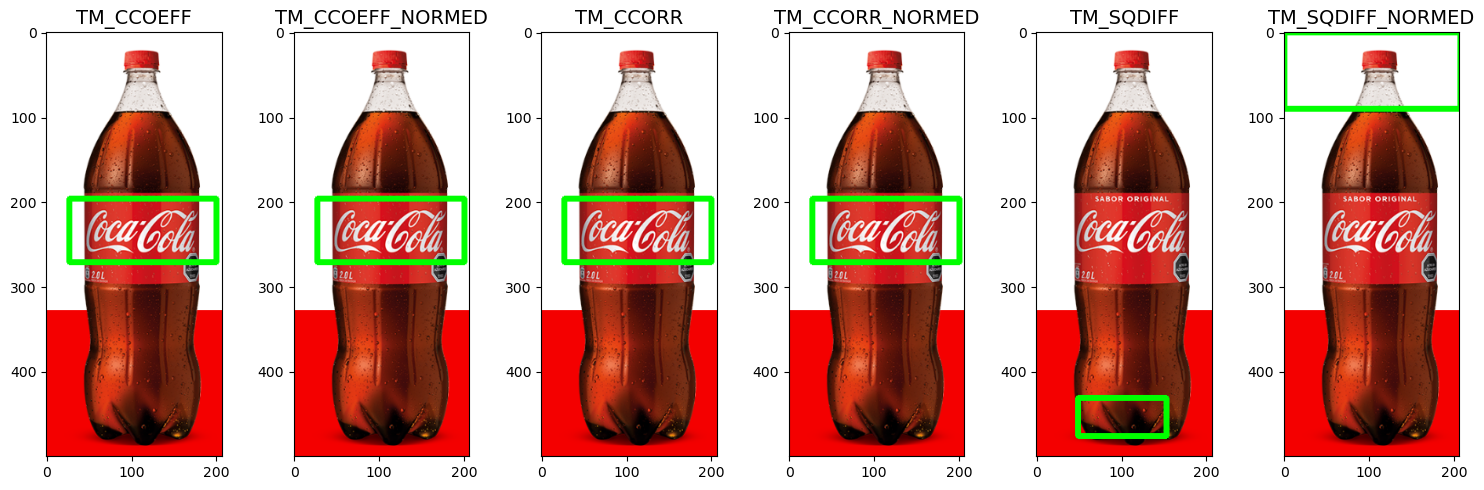

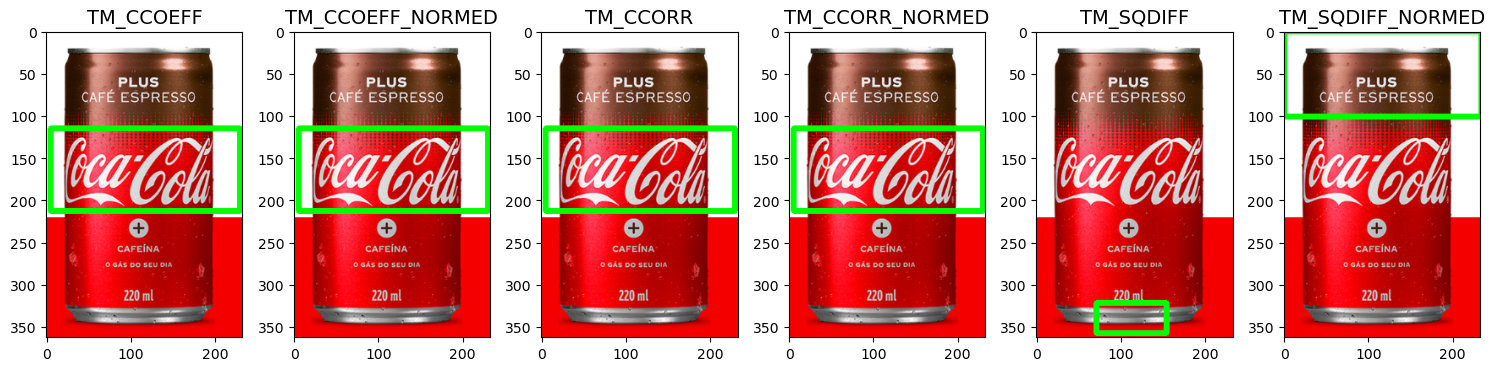

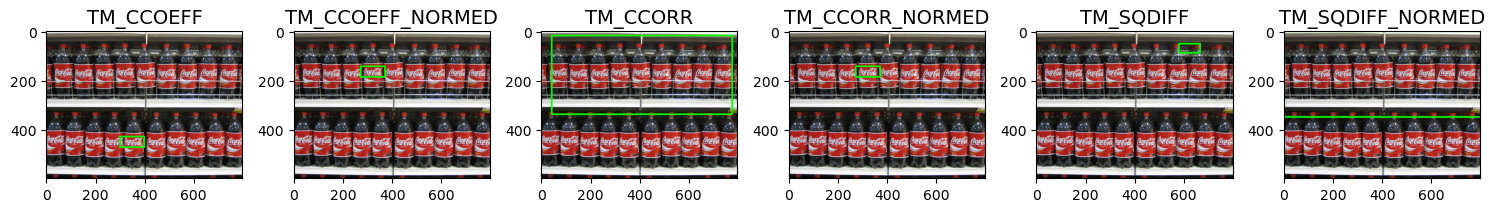

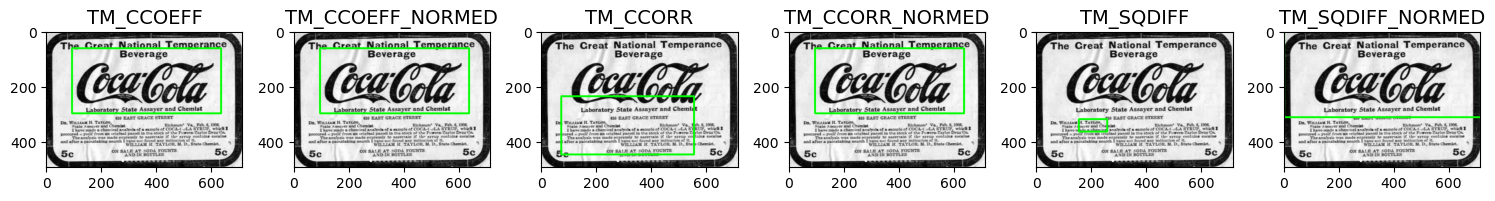

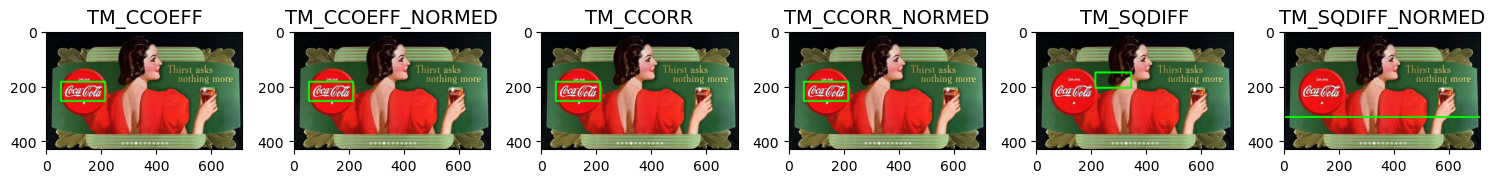

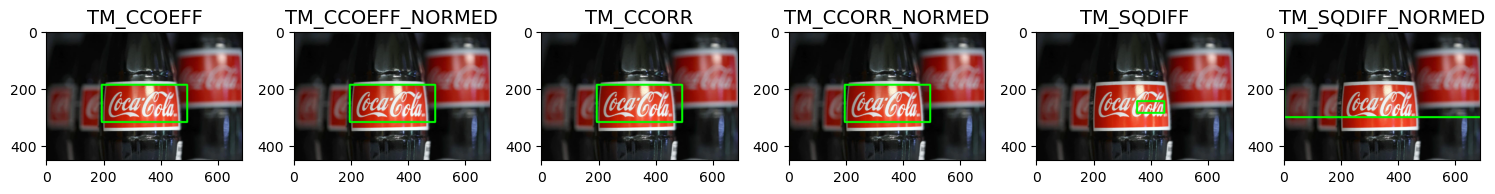

In [5]:
for img in images:
    match_template_single_detection_test_methods(img, template, methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED'])

Podemos observar que los métodos TM_CCOEFF y TM_CCORR_NORMED dieron buenos resultados para la detección sin falsos positivos para todas las imágenes.
Vamos a quedarnos con el método TM_CCOEFF.

##### Aplicamos el método de detección utilizando TM_CCOEFF

In [13]:
def  match_template_single_detection(img: np.ndarray, template: np.ndarray) -> None:
    """
    Recibe una imagen y un template a detectar en dicha imagen.

    :param img: Imagen en la cual se quiere detectar el template
    :type img: np.ndarray
    :param template: Template a detectar en la imagen
    :type template: np.ndarray
    """

    method: str = 'TM_CCOEFF'

    # conviertimos el template a escala de grises y aplicamos Canny
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    template_edges = cv.Canny(template_gray, 100, 200, L2gradient=True)

    # conviertimos la imagen a escala de grises
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
    # definimos las escalas
    h_image, w_image, _ = img.shape
    h_template, w_template  = template_edges.shape

    max_scale = 5.0
    min_scale = max(h_template / h_image, w_template / w_image)
    scales = np.linspace(min_scale, max_scale, 100)

    best_results = []
    results = []

    # iteramos sobre todas las escalas para buscar el mejor resultado
    for scale in scales:
            
        # escalamos y aplicamos Canny a la imagen
        img_scaled = cv.resize(img_gray, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)
            
        # aplicamos matchTemplate y buscamos el mejor resultado

        result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
        _, max_val, _, max_loc = cv.minMaxLoc(result)
        results.append(max_val)
        
        if best_results == [] or max_val > best_results[0]:
            best_results = [max_val, max_loc, (template_edges.shape), scale]
            
    # agregamos el borde a la imagen marcando donde se detectó el template
    img_plot = mark_template(img.copy(), best_results)

    # gráficamos
    show_images([img_plot], [f'Score detection: {best_results[0]}'])

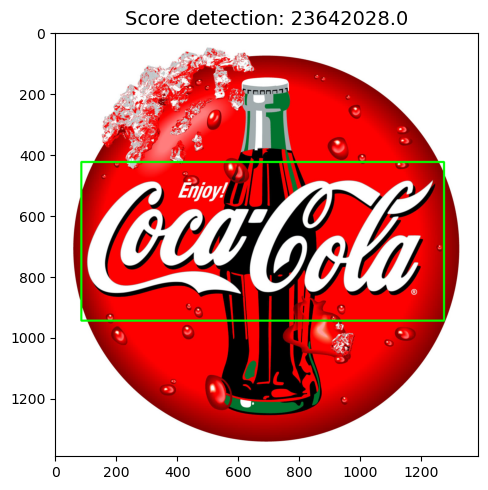

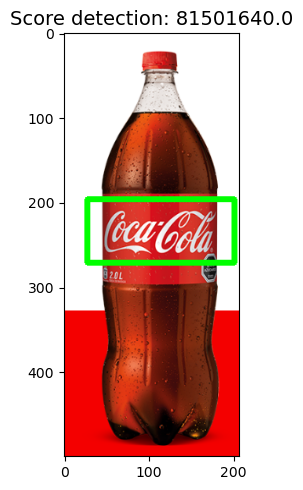

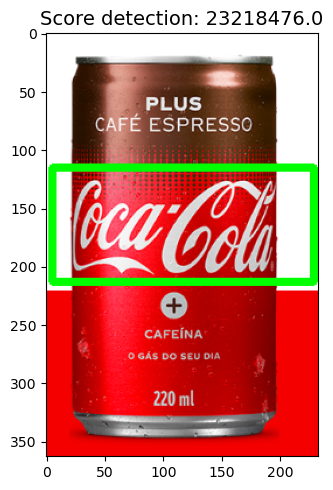

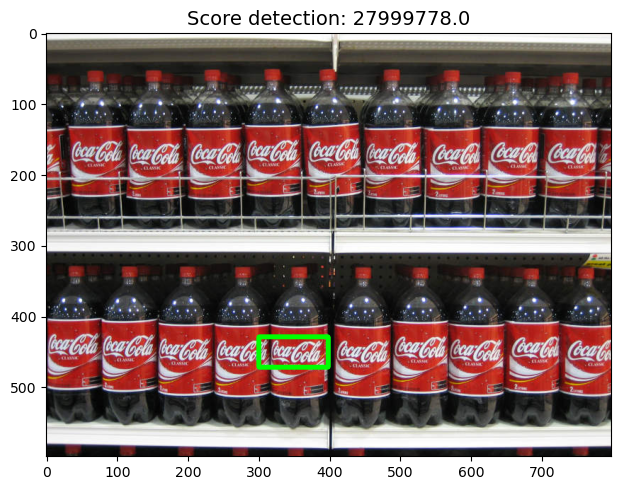

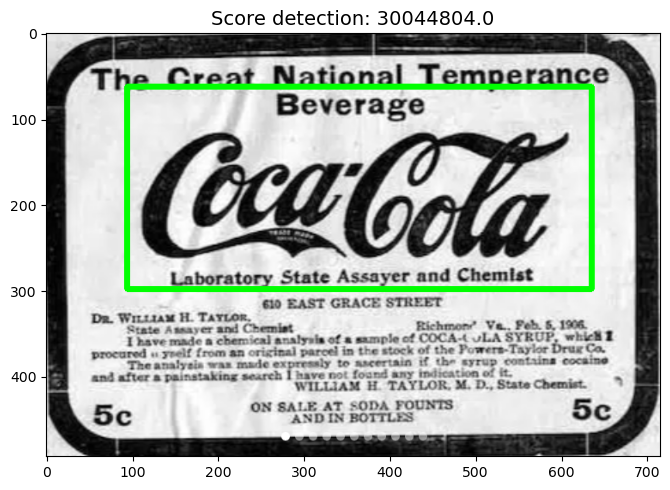

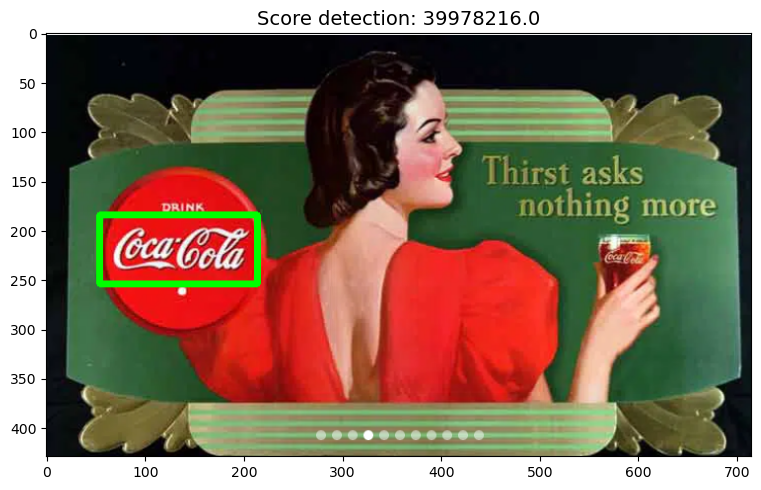

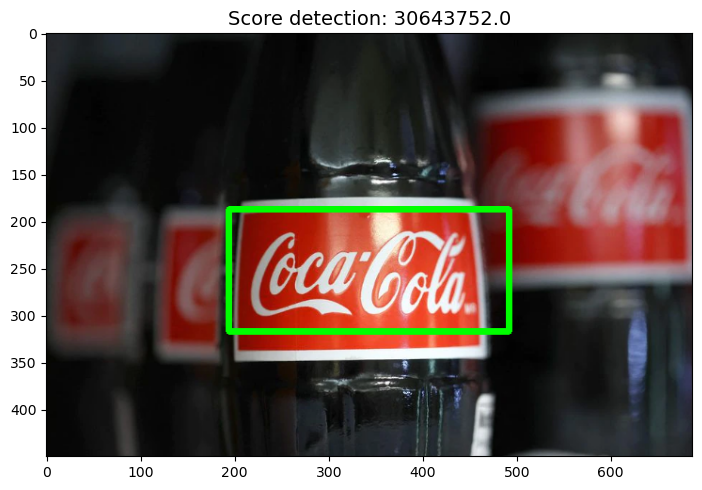

In [14]:
for img in images:
     match_template_single_detection(img, template)

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1